<a href="https://colab.research.google.com/github/proteus21/DATA-SCIENCE-STUDY/blob/main/Computer%20Vision/Computer_vision_exercises_part_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision - OpenCV - 8th Task (20 minutes)
@author Tomasz Skrzypczyk

Solved by Bogusław Konefał

In [ ]:
import tensorflow as tf
import numpy as np
import collections
from six.moves import urllib
import os
import random
import cv2

## The flowers dataset

The flowers dataset consists of images of flowers with 5 possible class labels.

When training a machine learning model, we split our data into training and test datasets. We will train the model on our training data and then evaluate how well the model performs on data it has never seen - the test set.

Let's download our training and test examples (it may take a while) and split them into train and test sets.

Run the following three cells:

# Importing the data

In [ ]:
# just run this cell
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in os.walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes

In [ ]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


In [ ]:
train_ds = [(cv2.resize(cv2.imread(path), (224,224))/255, label) for path, label in TRAIN_EXAMPLES]

def get_generator(ds):
  def data_generator():
    for i in range(len(ds)):
      yield ds[i][0], (ds[i][1],)
  return data_generator

train_ds = tf.data.Dataset.from_generator(get_generator(train_ds), output_types=(tf.float32, tf.uint8), output_shapes=((224,224,3),(1,)))
train_ds = train_ds.shuffle(100)
train_ds = train_ds.batch(64)

# AlexNet

In this section you will be asked to implement **AlexNet**. You will be given some code to start with.


The image shows how to build the architecture.

*    Google all layers that you need to add to the network. The documentation will tell you how to set the required parameters correctly.

*    You must specify an input shape in the `InputLayer` or add `input_shape` parameter to your first layer.

*    The Image also shows that you will need 5 different `Conv2D` layers with different kernel sizes and strides. Pay attention to the ouput dimensions, this will tell you how many filters you should put in each layer and what is the output shap of each layer. Run `model.summary()` if your model has the same output shapes.

*    We can see that the architecture uses Relu activation function. You don't need a separate layer for that. You can specify the activation function in the layer's definition.

* There is a flattening operation in the middle of the network. You can add flattening by adding a `Flatten' layer. This layer requires no additional parameters.

*    Pay attention to strides and paddings. The padding parameter shows how much padding you need to add, in practise you ony have to set padding to "same" or "valid".

*     Also, the authors used `Dropout` layer with `dropout_rate` = 0.5, we will discuss what that is later in this course. You can add this layer to your network but this is not mandatory.

* The last layer will have different number of neurons than the number specified in the image. The number of output layers must always mach the number of classes in your classification problem.

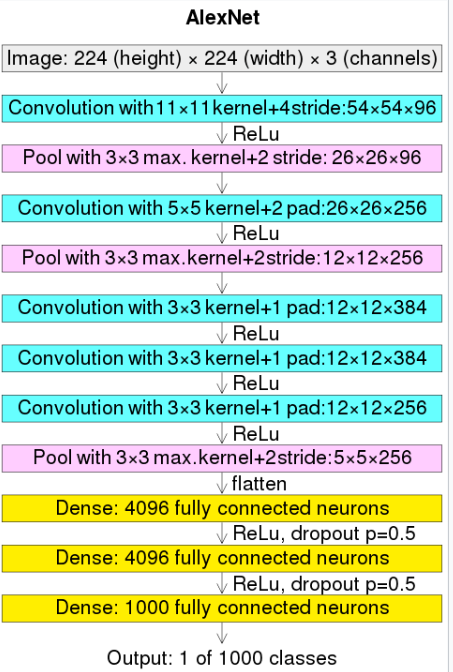

In [ ]:
# fill the missing spots, you have as many model.add(..) as it's required
# uncomment each line, add layer's definition, run the cell and monitor the summary

from tensorflow.python.ops.gen_dataset_ops import model_dataset
def create_model():
  model = tf.keras.Sequential()

  # --------------- bottom / backbone/ feature extraction network----------------
  
  model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=(4,4), padding="valid", input_shape=(224,224,3), activation="relu"))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

  model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding="same", activation="relu"))   
  model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

  model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding="same", activation="relu")) 
  model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding="same", activation="relu")) 
  model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")) 
  model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

  model.add(tf.keras.layers.Flatten())
  # GlobalPooling

  # --------------- top/ classifier ----------------
  model.add(tf.keras.layers.Dense(4096, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(4096, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(5, activation="relu"))



  return model
model = create_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 12, 12, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_32 (Conv2D)          (None, 12, 12, 384)      

In [ ]:
# Your summary should look like this:
# model.summary()

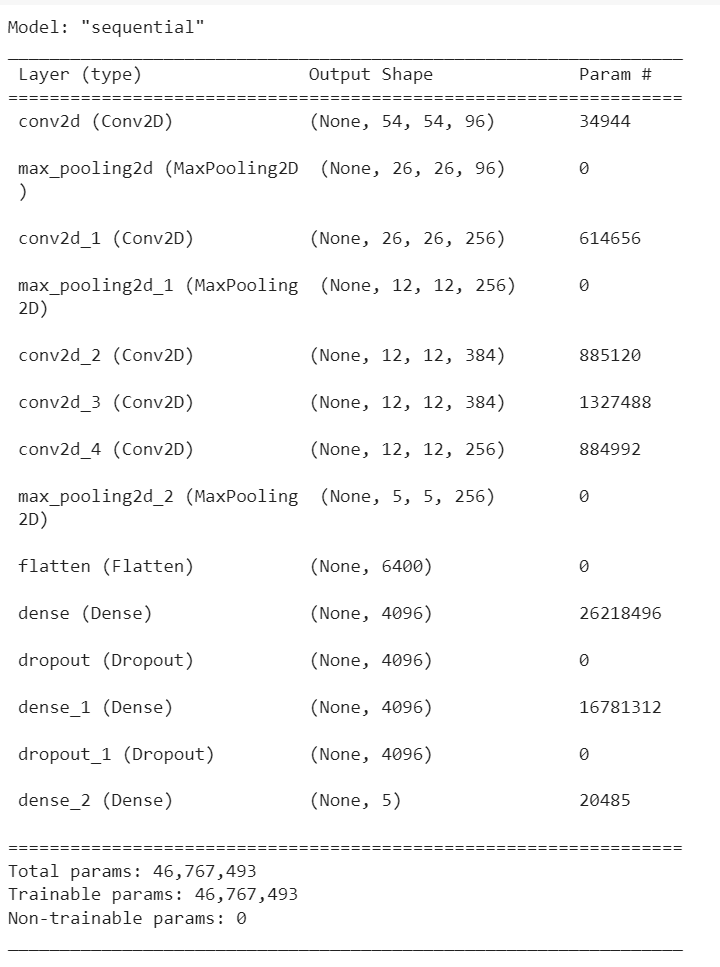

In [ ]:
# compile your model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Check if this cell gives you no errors
model.evaluate(train_ds)

46/46 [==============================] - 116s 3s/step - loss: 7.7385 - accuracy: 0.2062


[7.738513469696045, 0.2062031328678131]